In [118]:
#Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
plt.style.use('fivethirtyeight')
from pandas import Series
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']= 20,10
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [119]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
date = pd.read_csv("./Dados/AirPassengers.csv", parse_dates=['Month'], index_col='Month', date_parser=dateparse)

C:\Users\gustavo.aguiar\AppData\Local\Temp\ipykernel_16136\2028831510.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')


In [120]:
date.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


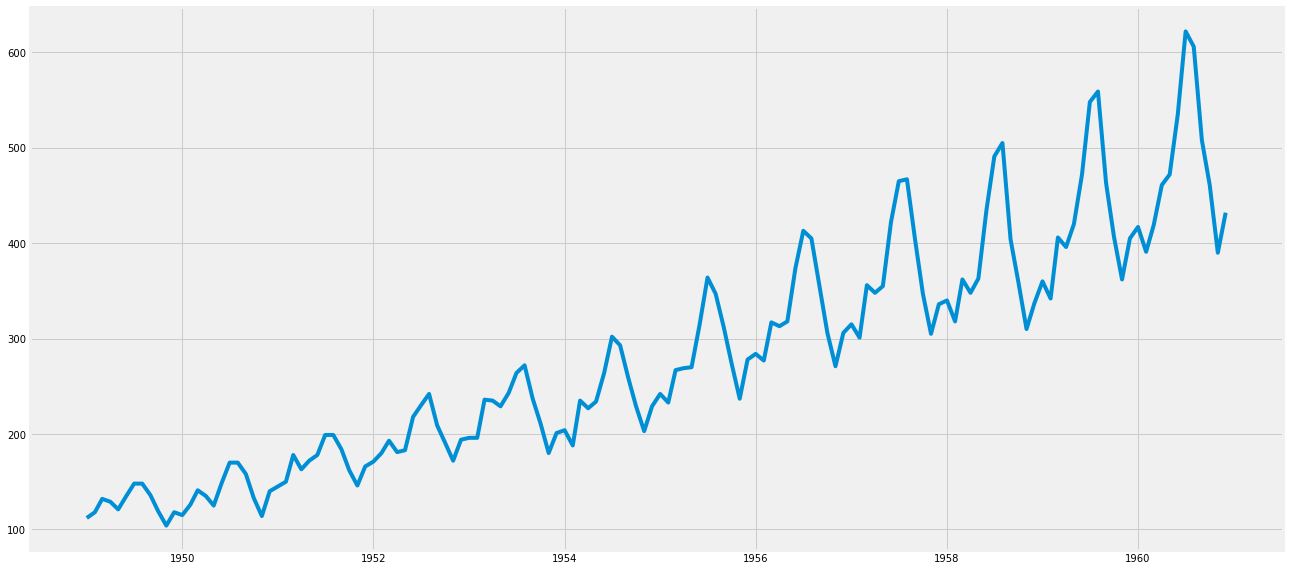

In [121]:
plt.plot(date)

In [122]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [123]:
result = seasonal_decompose(date, model='multiplicative')

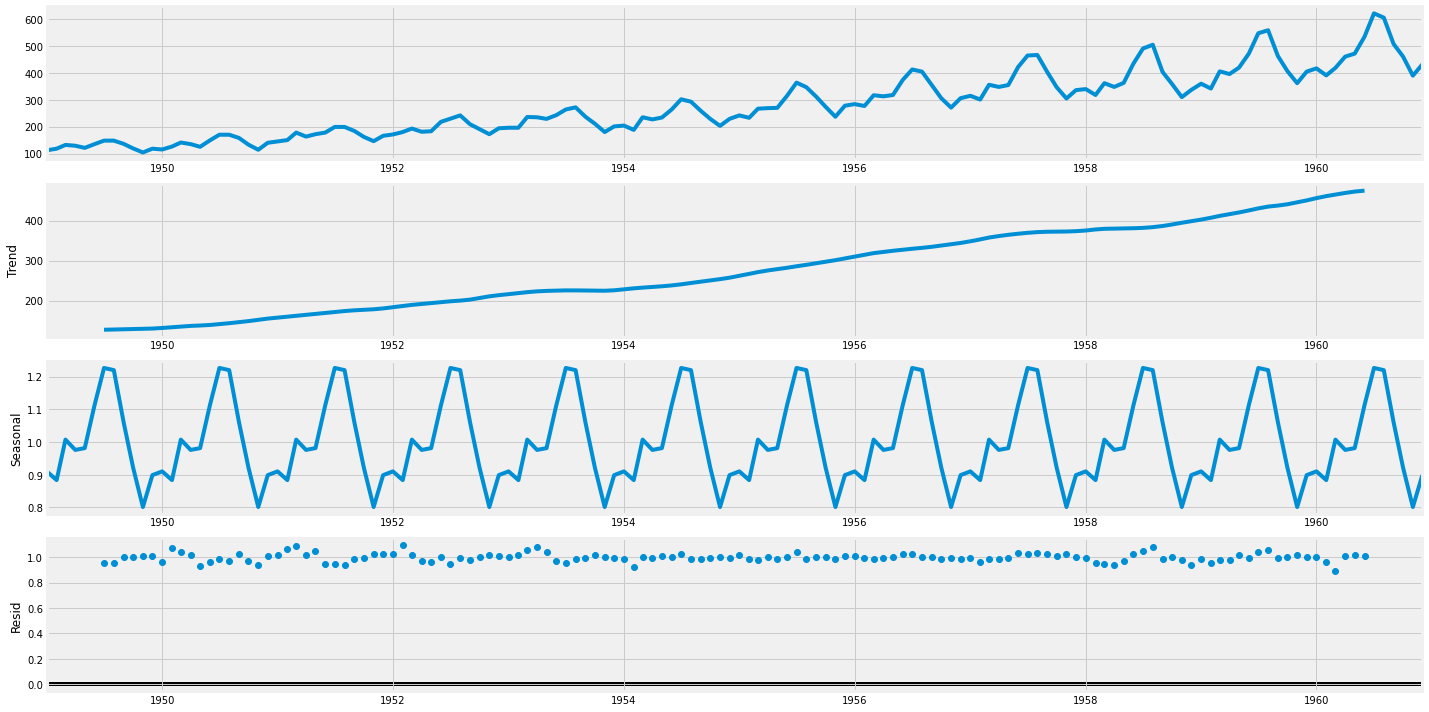

In [124]:
result.plot()
plt.show()

In [125]:
result2 = seasonal_decompose(date, model='aditive')

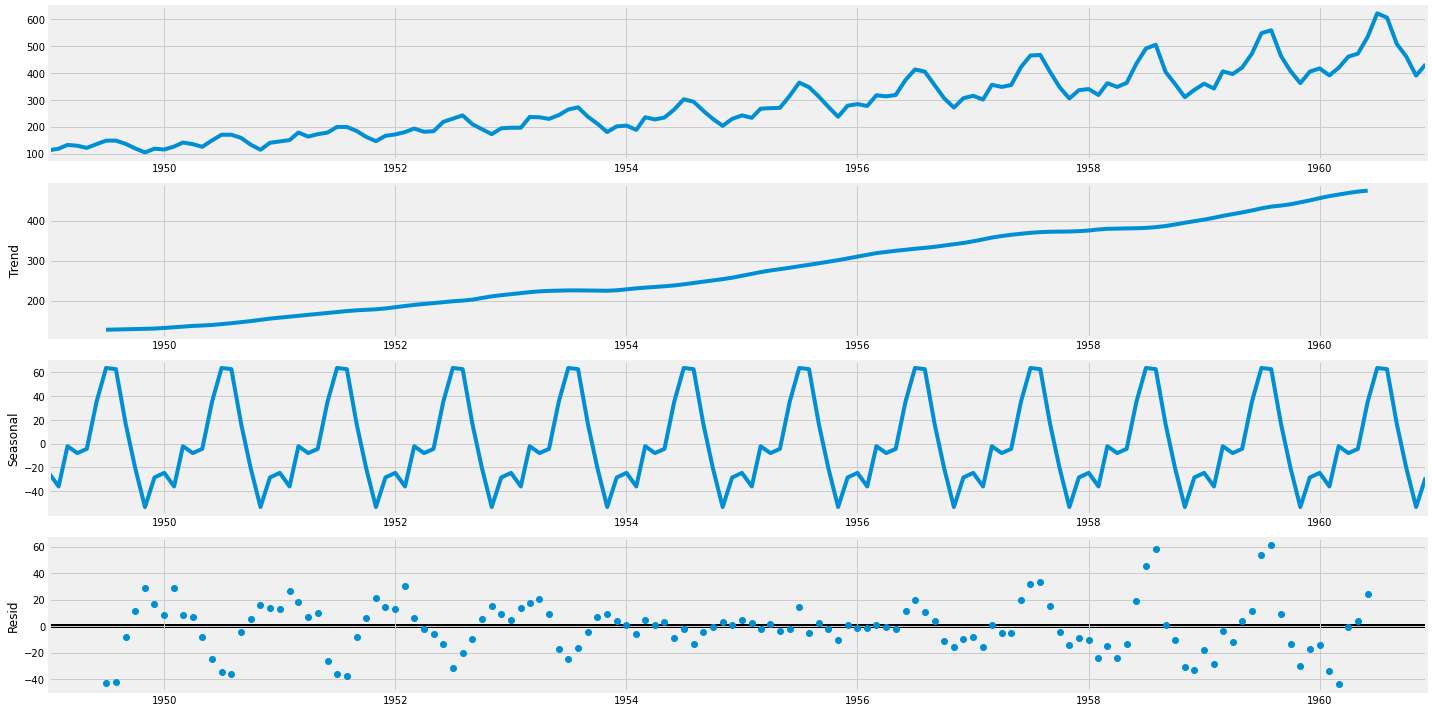

In [126]:
result2.plot()
plt.show()

# modelo linear

In [127]:


x = [i for i in range(0,len(date))]
x = np.reshape(x, (len(x),1))
y = date.values
x

array([[  0],
       [  1],
       [  2],
       [  3],
       [  4],
       [  5],
       [  6],
       [  7],
       [  8],
       [  9],
       [ 10],
       [ 11],
       [ 12],
       [ 13],
       [ 14],
       [ 15],
       [ 16],
       [ 17],
       [ 18],
       [ 19],
       [ 20],
       [ 21],
       [ 22],
       [ 23],
       [ 24],
       [ 25],
       [ 26],
       [ 27],
       [ 28],
       [ 29],
       [ 30],
       [ 31],
       [ 32],
       [ 33],
       [ 34],
       [ 35],
       [ 36],
       [ 37],
       [ 38],
       [ 39],
       [ 40],
       [ 41],
       [ 42],
       [ 43],
       [ 44],
       [ 45],
       [ 46],
       [ 47],
       [ 48],
       [ 49],
       [ 50],
       [ 51],
       [ 52],
       [ 53],
       [ 54],
       [ 55],
       [ 56],
       [ 57],
       [ 58],
       [ 59],
       [ 60],
       [ 61],
       [ 62],
       [ 63],
       [ 64],
       [ 65],
       [ 66],
       [ 67],
       [ 68],
       [ 69],
       [ 70],
      

In [128]:
from sklearn.linear_model import LinearRegression

In [129]:
model = LinearRegression()
model.fit(x,y)

LinearRegression()

In [130]:
trend = model.predict(x)

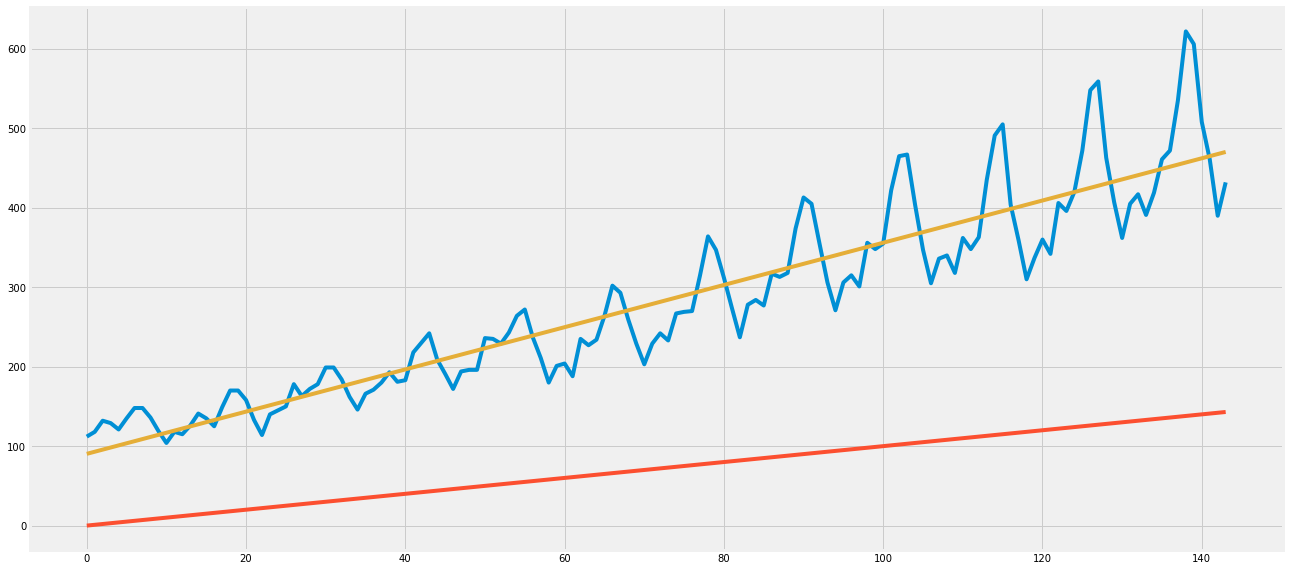

In [131]:
plt.plot(y)
plt.plot(x)
plt.plot(trend)
plt.show()

In [132]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [133]:
fit1 =  SimpleExpSmoothing(date).fit(smoothing_level=1)
fcast1 = fit1.forecast(12).rename(r'$alpha=0.2$')

C:\Users\gustavo.aguiar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<AxesSubplot:xlabel='Month'>

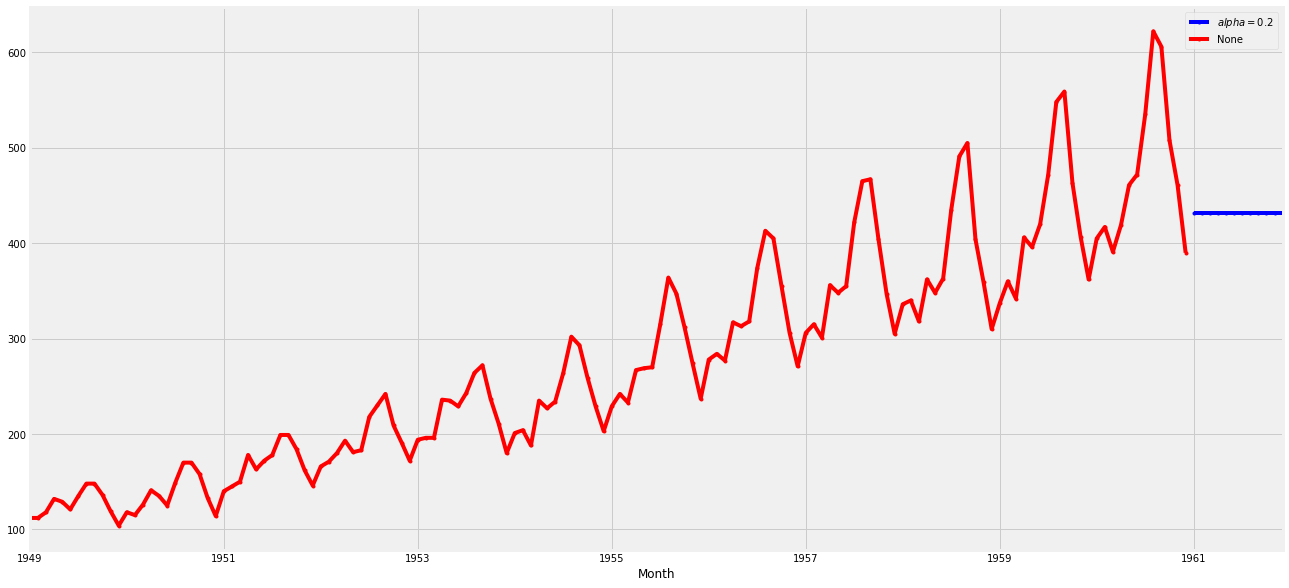

In [134]:
fcast1.plot(marker='.', color='blue',legend=True)
fit1.fittedvalues.plot(marker='.', color='red',legend=True)

# arima

In [ ]:
optimal_n = None
best_mse = None

db = date[['#Passengers']].values.astype('float32')
mean_results_for_all_possible_n_values = np.zeros(int(len(db) / 2 - 2))

for n in range(5, int(len(db) / 2 + 1)):
    mean_for_n = np.zeros(len(db)- n)
    
    for i in range(0, len(db) - n):
        mean_for_n[i] = np.power(np.mean(db[:,0][i:i+n]) - db[i + n][0],2)
    mean_results_for_all_possible_n_values[n - 3] = np.mean(mean_for_n)

optimal_n  = np.argmin(mean_results_for_all_possible_n_values) + 5
best_mse = np.min(mean_results_for_all_possible_n_values)

print(f'todos mse: {mean_results_for_all_possible_n_values}')
print(f"melhor mse: {best_mse}")
print("otimo n = %s"  % optimal_n)

In [ ]:
forecast = np.zeros(len(db)+1)
for i in range(0, optimal_n):
    forecast[i] = db[i][0]
for i in range(0, len(db) - optimal_n + 1):
    forecast[i+optimal_n] = np.mean(db[:,0][i:i+optimal_n])
plt.plot(db[:,0], label = 'dados originais')
plt.plot(forecast, label='previsao')
plt.legend()
plt.show()

# auto arima

In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
stepwise_model = auto_arima(date,start_p=1, start_q=1, max_p=6, max_q=6, m=12, start_P=0, seasonal=True, d=1, D=1
, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

In [ ]:
print(stepwise_model)
print(stepwise_model.aic())

In [ ]:
train = date.loc['1948-01-01':'1959-01-01']
test = date.loc['1960-01-01':]

In [ ]:
stepwise_model.fit(train)

In [ ]:
forecast = stepwise_model.predict(n_periods=12)

In [ ]:
forecast = pd.DataFrame(forecast, index=test.index,columns=['#Passengers'])

In [ ]:
pd.concat([date,train,forecast], axis=1).plot()
pd.concat([date,train,forecast], axis=1).plot(linewidth=3)

# random forest

In [ ]:
from pandas import Series

In [ ]:
diff = date.diff(12)
diff = diff[12:]
diff.head(n=13)

In [ ]:
diff.plot()

In [ ]:
dataframe = pd.DataFrame()
for i in range(12,0,-1):
    dataframe['t-' + str(i)] = diff.shift(i)
    dataframe['t'] = diff.values
print(dataframe.head(13))
dataframe = dataframe[13:]

In [ ]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

In [ ]:
array = dataframe.values
x = array[:,0:-1]
y = array[:,-1]

In [ ]:
model = RandomForestRegressor(n_estimators=500, random_state=1)

In [ ]:
print(model)

In [ ]:
names = dataframe.columns.values[0:-1]
ticks = [i for i in range(len(names))]
plt.bar(ticks, model.features_importances_)
plt.xticks(ticks, names)
plt.show()

# prophet

In [ ]:
from fbprophet import Prophet

# Redes neurais

In [138]:
df = pd.read_csv("./Dados/AirPassengers.csv", sep = ';', parse_dates=True, index_col=0)
data = df.values
np.random.seed(3)

In [139]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.model_selection import train_test_split

In [140]:
data = date.astype('float32')

In [141]:
# size = len(data)


# train = int(len(data) * 0.8)
# test = int(len(data) * 0.2)
# train_2 = train + 1

# train = data[:train]
# test = data[train_2:]

# print(train)
# print(test)

# train.shape, test.shape

train = data[0:125,:]
test = data[125:,:]

InvalidIndexError: (slice(0, 125, None), slice(None, None, None))

In [142]:
def prepare_data(data, lags=1):
    X, y = [] , []
    for row in range(len(data) - lags - 1):
        a = data[row:(row + lags),0]
        X.append(a)
        y.append(data[row + lags, 0])
    return np.array(X) , np.array(y)

In [143]:


x_train, x_test, y_train, y_test = train_test_split(x, y)




# lags=1

# X_train , y_train, X_test , y_test = prepare_data(train, lags)
# y_true = y_test

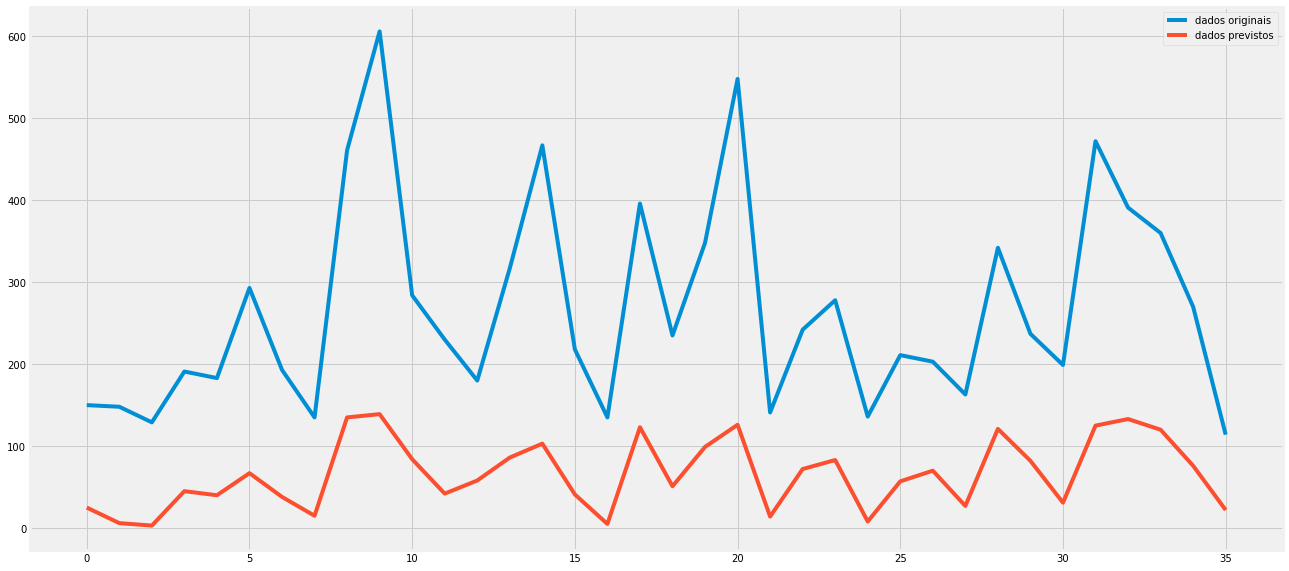

In [144]:
plt.plot(y_test, label = 'dados originais')
plt.plot(x_test, label = 'dados previstos')
plt.legend()
plt.show()

In [154]:
md1 = Sequential()
md1.add(Dense(3,input_dim=lags, activation='relu'))
md1.add(Dense(1))
md1.compile(loss='mean_squared_error',optimizer='adam')
md1.fit(x_train,y_train)

4/4 [==============================] - 1s 3ms/step - loss: 65478.1289


In [159]:
train_score = md1.evaluate(x_train,y_train)
print('pontuacao de treino: {:.2f} mse ({:.2f} rsme)'. format(train_score,math.sqrt(train_score)))

test_score = md1.evaluate(x_test,y_test)
print('pontuacao de teste: {:.2f} mse ({:.2f} rsme)'. format(test_score,math.sqrt(test_score)))

4/4 [==============================] - 0s 3ms/step - loss: 65169.8438
pontuacao de treino: 65169.84 mse (255.28 rsme)
2/2 [==============================] - 0s 6ms/step - loss: 60510.2852
pontuacao de teste: 60510.29 mse (245.99 rsme)


In [160]:
train_predict = md1.predict(x_train)
test_predict = md1.predict(x_test)

2/2 [==============================] - 0s 3ms/step


In [177]:
train_predict_plot = np.empty_like(data)
train_predict_plot[:,:] = np.nan
train_predict_plot[lags: len(train_predict) + lags, :] = train_predict
train_predict

array([[1.09414215e+01],
       [8.23137283e+01],
       [8.81006775e+01],
       [1.47993841e+01],
       [4.95210495e+01],
       [5.59509888e+01],
       [7.20258255e+01],
       [2.25153103e+01],
       [6.10949364e+01],
       [4.37341042e+01],
       [2.18723183e+01],
       [3.40892029e+01],
       [1.22274084e+01],
       [3.21602173e+01],
       [8.74576874e+01],
       [2.58250260e+00],
       [7.72645235e+00],
       [5.65939827e+01],
       [4.18051262e+01],
       [6.44046497e+00],
       [7.33118134e+01],
       [7.08345842e+00],
       [8.35997162e+01],
       [7.84557724e+01],
       [9.13156433e+01],
       [7.26688232e+01],
       [3.02312355e+01],
       [7.52407990e+01],
       [5.79747105e+00],
       [4.69490700e+01],
       [5.72369728e+01],
       [7.97417603e+01],
       [2.50872860e+01],
       [6.43099060e+01],
       [7.13828430e+01],
       [6.94538574e+01],
       [3.79471626e+01],
       [8.61716919e+01],
       [2.83022556e+01],
       [2.31583061e+01],


In [191]:
test_predict_plot = np.empty_like(data)
test_predict_plot[:,:] = np.nan
test_predict_plot[(len(train_predict)+(lags*2)+1):(len(data)-1),:]

array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]], dtype=float32)

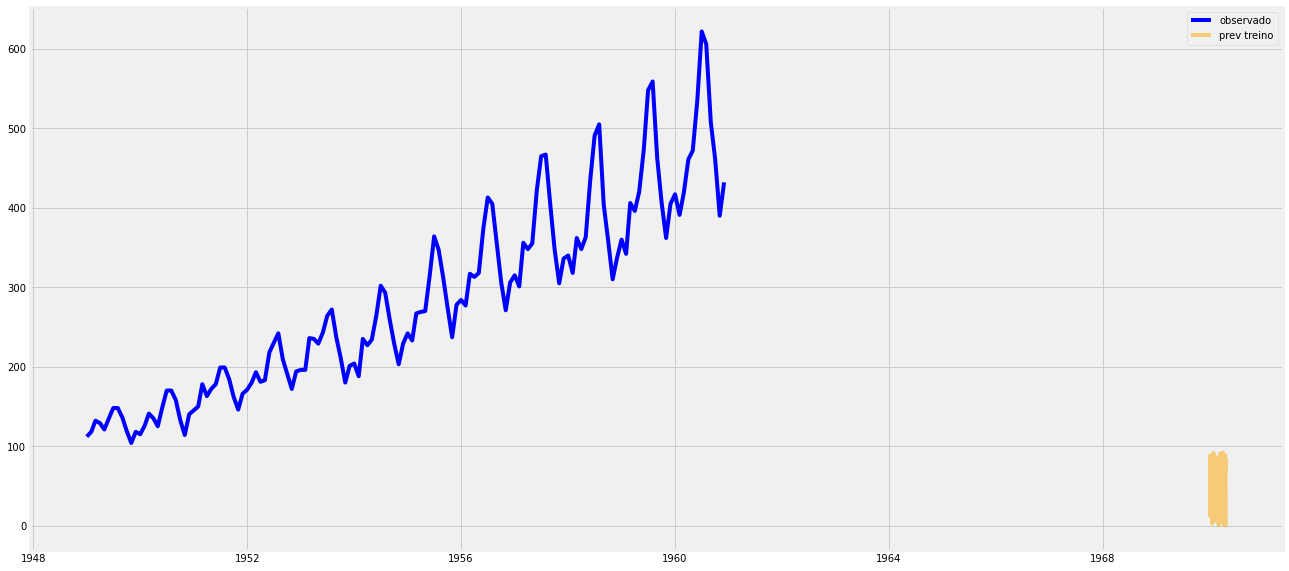

In [192]:
plt.plot(data, label='observado', color='blue')
plt.plot(train_predict, label='prev treino', color='orange', alpha=0.5)
# plt.plot(test_predict_plot)
plt.legend()
plt.show()

# holt_winters

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import warnings
warnings.filterwarnings('ignore')

In [195]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv("./Dados/AirPassengers.csv", parse_dates=['Month'], index_col='Month',date_parser=dateparse)

In [196]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [200]:
fit1 = ExponentialSmoothing(data, seasonal_periods=12, trend='additive', seasonal='additive').fit()#use_boxcox=True

<AxesSubplot:>

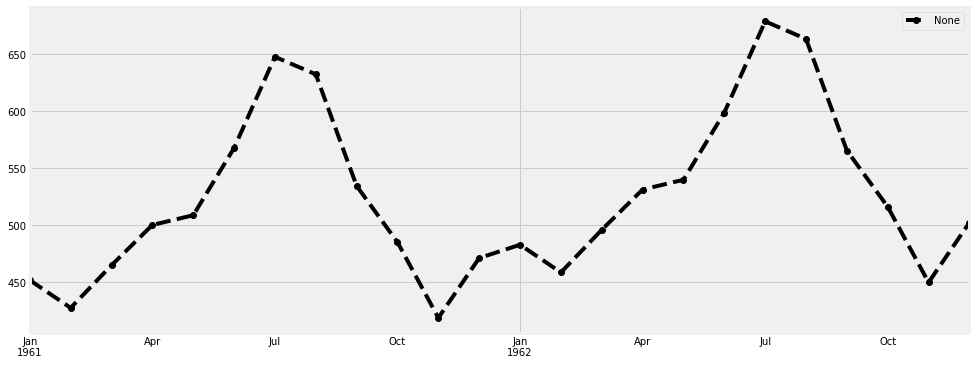

In [201]:
fit1.forecast(24).plot(style='--', marker='o', color='black', legend=True)

<AxesSubplot:xlabel='Month'>

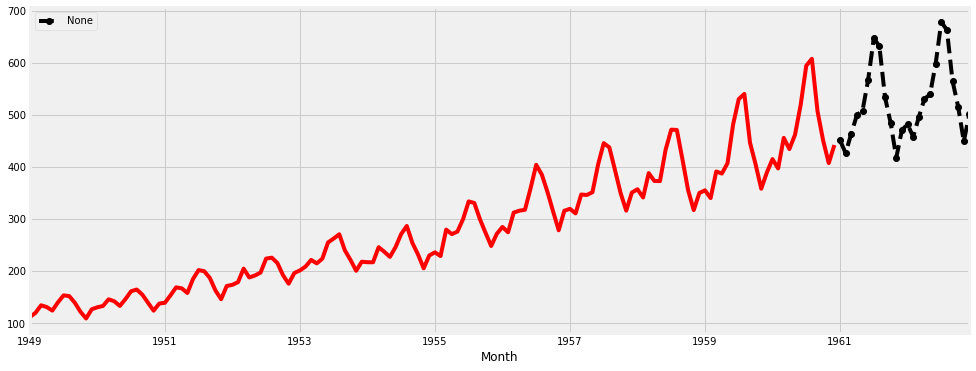

In [215]:
fit1.fittedvalues.plot(style='-', color='red')
fit1.forecast(24).plot(style='--', marker='o', color='black', legend=True)